In [106]:
#Here info:
#App ID: gB5Th31Aa7kCMDRB2yYH
#App Code: _V3OMdtHzj0vDll0eT6JsA

from sklearn.ensemble import RandomForestClassifier
from sklearn import (metrics, model_selection, linear_model, preprocessing, ensemble, neighbors, tree)
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pydotplus
import seaborn as sns
import numpy as np
import pandas as pd
import pprint as pp
import re
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier,plot_tree,to_graphviz
from IPython.display import Image 

%matplotlib inline

In [3]:
import txdot_parse as txpars

In [ ]:
# import the "crash" data
data = pd.read_csv("my_map_grid.csv",header=10)

In [ ]:
# preprocessing
# lowercase: http://stackoverflow.com/a/38931854
data.columns = data.columns.str.lower()
# remove spaces
data.columns = data.columns.str.replace(' ', '_')
# special cases
data.columns = data.columns.str.replace('crash_i_d', 'crash_id')
# remove whateva data

# replace ['No Data','Not Applicable'] with NaN
data.replace(to_replace='No Data', value=np.nan, inplace=True)
data.replace(to_replace='Not Applicable', value=np.nan, inplace=True)
data.latitude = pd.to_numeric(data.latitude)
data.longitude = pd.to_numeric(data.longitude)

In [13]:
data.speed_limit.replace(0,np.nan,inplace=True)
data.speed_limit.replace(-1,np.nan,inplace=True)
# impute speed limits
print("########################################")
verbose=0
if(verbose):
    print(data.speed_limit.value_counts())
totalmissing   = data[data['speed_limit'].isnull()].shape[0]
missingpercent = totalmissing / data.shape[0]
print("pre : total missing speed limit data:\n %s (%s of 1)" % (totalmissing, missingpercent))
if(verbose):
    print(data.speed_limit.unique())
data = txpars.impute_mph(data, verbose=0)
totalmissing   = data[data['speed_limit'].isnull()].shape[0]
missingpercent = totalmissing / data.shape[0]
print("post: total missing speed limit data:\n %s (%s of 1)" % (totalmissing, missingpercent))
if(verbose):
    print(data.speed_limit.unique())
    print(data.speed_limit.value_counts())
    print(data.info())
print("########################################")

########################################
pre : total missing speed limit data:
 458 (0.20519713261648745 of 1)
post: total missing speed limit data:
 458 (0.20519713261648745 of 1)
########################################


Tree train accuracy:  0.617391304348
Tree test accuracy:  0.575305291723


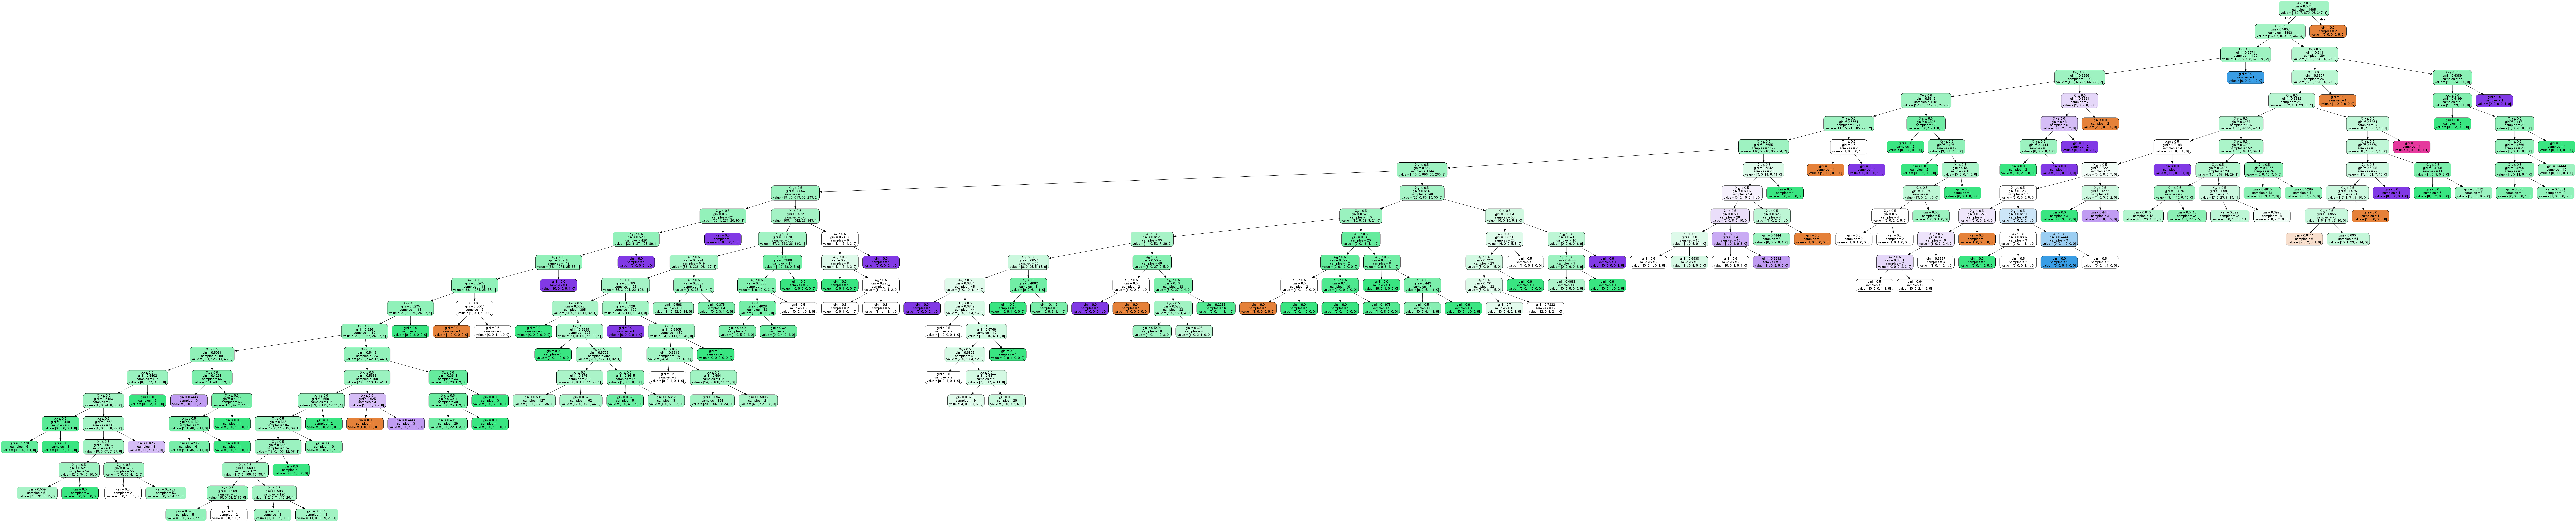

In [14]:
# Use DecisionTreeClassifier with a limited number of features and visualize
# the the resulting tree

# https://research.vahula.com/scikit-learns-decision-tree-classifier-698ddbb05b
# http://scikit-learn.org/stable/modules/tree.html





# Let's select a small number of important features
# smalldf = data[['crash_severity',
#                 'crash_time', 
#                 'day_of_week', 
#                 'intersection_related', 
#                 'light_condition', 
#                 'manner_of_collision',
#                 'speed_limit',
#                 'surface_condition', 
#                 'weather_condition']]

# smalldf.head()

# dummies_needed_list = [
#  'day_of_week',
#  'intersection_related',
#  'light_condition',
#  'manner_of_collision',
#  'surface_condition',
#  'weather_condition']

smalldf = data[['crash_severity', 
                'intersection_related', 
                'light_condition', 
                'manner_of_collision',
                'surface_condition', 
                'weather_condition']]

smalldf.head()

dummies_needed_list = [
 'intersection_related',
 'light_condition',
 'manner_of_collision',
 'surface_condition',
 'weather_condition']

# encode data for dummies_needed_list
for feat in dummies_needed_list:
    smalldf = pd.concat([smalldf,pd.get_dummies(smalldf[feat],prefix=feat)],axis=1)
    smalldf = smalldf.drop([feat],axis=1)
    
smalldf.head()
X = smalldf.drop(['crash_severity'], axis=1)
y = smalldf['crash_severity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

tree_classifier = tree.DecisionTreeClassifier()
tree_classifier.fit(X_train, y_train)

train_accuracy = tree_classifier.score(X_train, y_train)
test_accuracy = tree_classifier.score(X_test, y_test)
print('Tree train accuracy: ', train_accuracy)
print('Tree test accuracy: ', test_accuracy)

# graphviz needs to be installed
# on mac: brew install graphviz
# http://stackoverflow.com/questions/18438997/why-is-pydot-unable-to-find-graphvizs-executables-in-windows-8

# The feature_names and class_names oprtional parameters should be set so that the tree
# can have the actual names of features and classes
# http://scikit-learn.org/stable/modules/tree.html#classification
dot_data = tree.export_graphviz(tree_classifier, out_file=None, 
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 

#print(tree_classifier.feature_importances_)


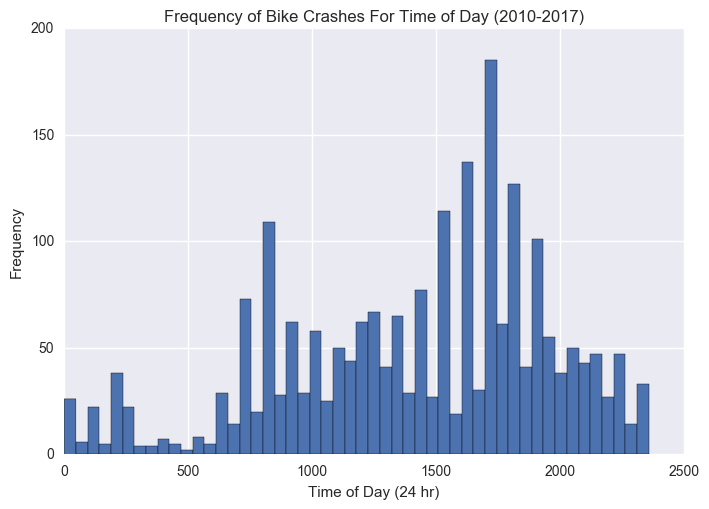

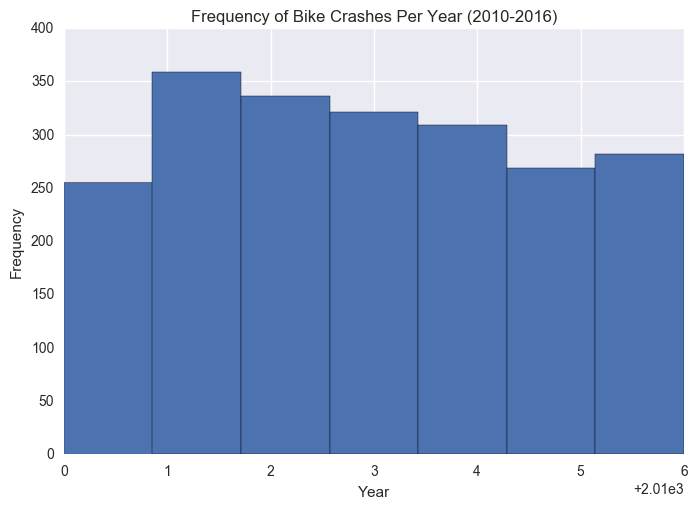

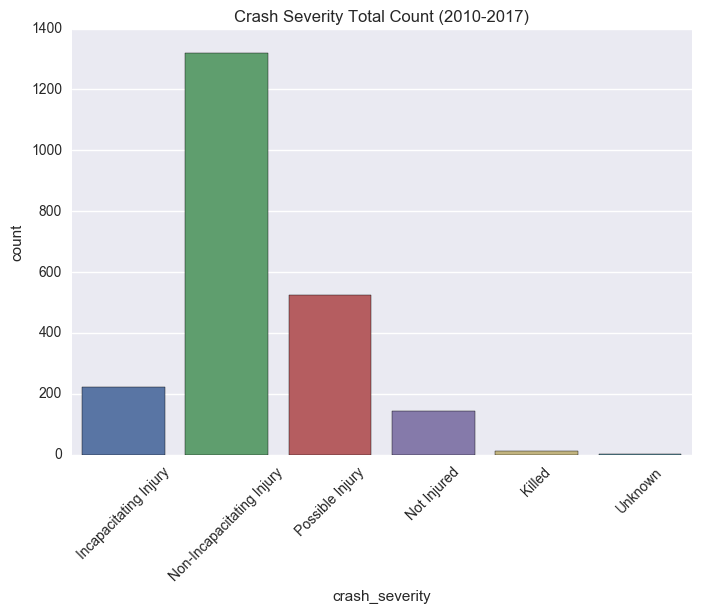

In [3]:
# Let's see the realationship between crashes and time of day
# First, let's just look at the total crashes vs time of day (no crash severity)

data = pd.read_csv("my_map_grid.csv",header=10)
data.columns = data.columns.str.lower()
# remove spaces
data.columns = data.columns.str.replace(' ', '_')

data.crash_time.plot.hist(bins=50)
plt.xlabel('Time of Day (24 hr)')
plt.title('Frequency of Bike Crashes For Time of Day (2010-2017)')
plt.show()

# Let's see if there is a trend of total bike crashes by year
# We'll ignore 2017 data since it is incomplete
data.crash_year[data.crash_year != 2017].plot.hist(bins=7)
plt.xlabel('Year')
plt.title('Frequency of Bike Crashes Per Year (2010-2016)')
plt.show()

# Spread of Crash Severity data from 2010-2017
# Using seaborn for ease of use with categorical data
sns.countplot(x="crash_severity", data=data);
plt.xticks(rotation=45)
plt.title('Crash Severity Total Count (2010-2017)')
plt.show()


In [122]:
# import the "crash" data
data = pd.read_csv("my_map_grid.csv",header=10)

# preprocessing
# lowercase: http://stackoverflow.com/a/38931854
data.columns = data.columns.str.lower()
# remove spaces
data.columns = data.columns.str.replace(' ', '_')
# special cases
data.columns = data.columns.str.replace('crash_i_d', 'crash_id')
# remove whateva data

# replace ['No Data','Not Applicable'] with NaN
data.replace(to_replace='No Data', value=np.nan, inplace=True)
data.replace(to_replace='Not Applicable', value=np.nan, inplace=True)
data.latitude = pd.to_numeric(data.latitude)
data.longitude = pd.to_numeric(data.longitude)


dummies_needed_list = [
 'day_of_week',
 'intersection_related',
 'light_condition',
 'manner_of_collision',
 'road_base_type',
 'surface_condition',
 'weather_condition'
        ]

# encode data for dummies_needed_list
for feat in dummies_needed_list:
    data = pd.concat([data,pd.get_dummies(data[feat],prefix=feat)],axis=1)
    data = data.drop([feat],axis=1)

#remove data that will not be usefull
drop_columns = ['crash_id',
                'average_daily_traffic_amount',
                'average_daily_traffic_year',
                'street_name',
                'intersecting_street_name',
                'medical_advisory_flag',
                'object_struck',
               'crash_death_count',
               'crash_incapacitating_injury_count',
                'crash_non-incapacitating_injury_count',
               'crash_not_injured_count',
               'crash_possible_injury_count']
crash_id = data.crash_id
data = data.drop(drop_columns,axis=1)

#fix time column
data['100th_time']=data.crash_time/100
data['minutes'] = (data['100th_time']-data['100th_time'].apply(np.floor))*100
data['100th_time'] = (data['100th_time'].apply(np.floor))*60
data.crash_time = data.minutes+data['100th_time']
data.drop(['minutes'],axis=1,inplace=True)
data.drop(['100th_time'],axis=1,inplace=True)

#fill missing values
data = data.fillna(data.mean())

#split data into train/test,x/y
np.random.seed(0)
train, test = train_test_split(data)
x_train = train.drop(['crash_severity'],axis=1)
y_train = train.crash_severity
x_test = test.drop(['crash_severity'],axis=1)
y_test = test.crash_severity


C:\Users\weyma\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\weyma\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\weyma\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\weyma\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The mi

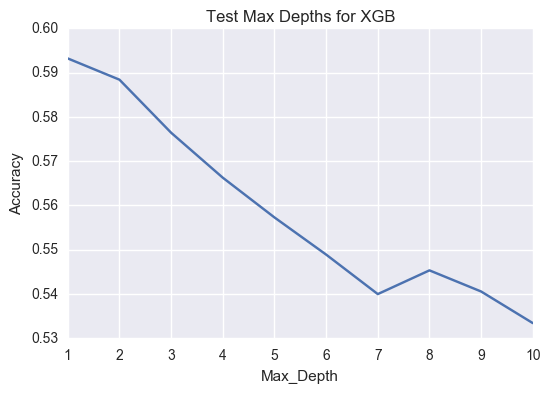

In [123]:
#cross validation function
def accuracy_cv(model):
    accuracy = cross_val_score(model,x_train,y_train.as_matrix().ravel(),scoring='accuracy',cv=5)
    return (accuracy)

max_depths = np.linspace(1,10,10,dtype=int)

#cross validation for max_depth parameter
cv_xgb = [accuracy_cv(XGBClassifier(max_depth=max_depth)).mean()
          for max_depth in max_depths]
#plot results
cv_xgb = pd.Series(cv_xgb, index = max_depths)
cv_xgb.plot(title = "Test Max Depths for XGB")
plt.xlabel("Max_Depth")
plt.ylabel("Accuracy")
best_max_depth = cv_xgb.idxmax()



C:\Users\weyma\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\weyma\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\weyma\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\weyma\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The mi

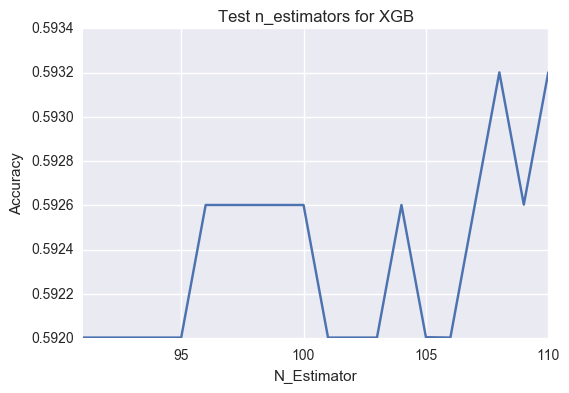

In [110]:
#cross validation for n_estimators
nestimators = np.linspace(91,110,dtype=int)
cv_xgb = [accuracy_cv(XGBClassifier(max_depth=best_max_depth,n_estimators=nestimator)).mean()
          for nestimator in nestimators]
#plot results
cv_xgb = pd.Series(cv_xgb, index = nestimators)
cv_xgb.plot(title = "Test n_estimators for XGB")
plt.xlabel("N_Estimator")
plt.ylabel("Accuracy")
best_n_estimators = cv_xgb.idxmax()

C:\Users\weyma\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\weyma\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\weyma\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\weyma\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The mi

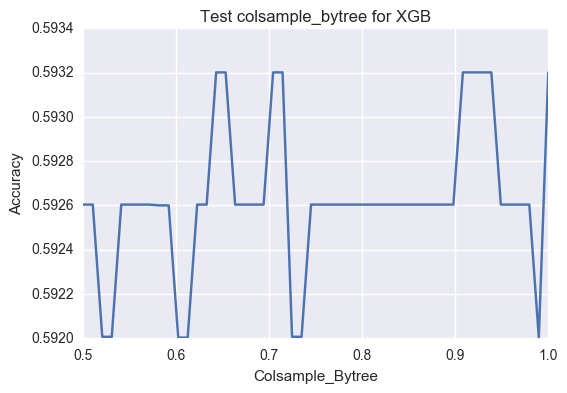

In [112]:
#cross validation for colsample_bytree
colsample_bytree = np.linspace(.5,1)
cv_xgb = [accuracy_cv(XGBClassifier(max_depth=best_max_depth,n_estimators=best_n_estimators,colsample_bytree=i)).mean()
          for i in colsample_bytree]
#plot results
cv_xgb = pd.Series(cv_xgb, index = colsample_bytree)
cv_xgb.plot(title = "Test colsample_bytree for XGB")
plt.xlabel("Colsample_Bytree")
plt.ylabel("Accuracy")
best_colsample_bytree = cv_xgb.idxmax()

XGB Train accuracy: 0.595579450418
XGB Test accuracy: 0.58064516129

crash_time : 0.211838
crash_year : 0.046729
latitude : 0.277259
longitude : 0.138629
speed_limit : 0.046729
day_of_week_Friday : 0.0155763
day_of_week_Monday : 0.00311526
day_of_week_Saturday : 0.0311526
day_of_week_Tuesday : 0.00311526
intersection_related_Driveway Access : 0.0218069
intersection_related_Non Intersection : 0.076324
light_condition_Dark, Lighted : 0.0109034
light_condition_Dawn : 0.00155763
light_condition_Dusk : 0.0186916
manner_of_collision_One Motor Vehicle - Backing : 0.00311526
manner_of_collision_One Motor Vehicle - Turning Right : 0.0186916
road_base_type_Flex Base (Granular) : 0.0280374
surface_condition_Dry : 0.00311526
surface_condition_Wet : 0.0109034
weather_condition_Rain : 0.0327103


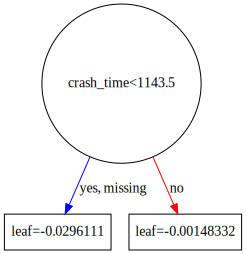

In [126]:
#train xgb model and check performance
model_xgb = XGBClassifier(max_depth=1,colsample_bytree=best_colsample_bytree,n_estimators=best_n_estimators)
model_xgb.fit(x_train,y_train)
print("XGB Train accuracy:", model_xgb.score(x_train,y_train))
print("XGB Test accuracy:",model_xgb.score(x_test,y_test))

#print important features list and their overall importance in the xgb model
print()
for i in range(0,len(model_xgb.feature_importances_)):
    if model_xgb.feature_importances_[i]!=0:
        print(x_train.columns[i],":",model_xgb.feature_importances_[i])

to_graphviz(model_xgb)